<a href="https://colab.research.google.com/github/cloudsen12/examples/blob/master/example02.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<br>

<a href="https://github.com/cloudsen12/examples/blob/main/example02.ipynb"><img align="left" src="https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white"></a>


<br><br>

<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://cloudsen12.github.io/thumbnails/cloudsen12.gif" width=10% >


>>>> *This notebook is part of the paper [CloudSEN12 - a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2](https://cloudsen12.github.io/); the content is available [on GitHub](https://github.com/cloudsen12)* and released under the [MIT](https://opensource.org/licenses/MIT) license. 

<br>

- See our paper [here](https://www.nature.com/articles/s41597-022-01878-2).

- See cloudSEN12 website [here](https://cloudsen12.github.io/).

- See cloudSEN12 in Science Data Bank [here](https://www.scidb.cn/en/detail?dataSetId=f72d622ff4ea4fa18070456a98222b1a).

- See cloudSEN12 in Google Drive [here](https://drive.google.com/drive/folders/1H_Qxy1yX6moqFbKc3Ajn4FFrHlDhYuz3).

- See cloudSEN12 in GitHub [here](https://github.com/cloudsen12).

- See cloudSEN12 in Google Earth Engine [here](https://samapriya.github.io/awesome-gee-community-datasets/projects/cloudsen12/).

- See CloudApp [here](https://csaybar.users.earthengine.app/view/cloudapp).

The CloudSEN12 dataset and the pre-trained models are released under a [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) licence. For using the models in comercial pipelines written consent by the authors must be provided.

### **1. Install the cloudsen12 Python package**

In [ ]:
!pip install cloudsen12

In [ ]:
import cloudsen12

### **2. Download a Sentinel-2 scene**

In [ ]:
# Donwload S2 an create a TenSorSat object
productid = "S2B_MSIL1C_20190523T150729_N0207_R082_T18MZA_20190523T183104"
s2idpath = cloudsen12.download(productid, "/content/", quiet=False)

### **3. Create a Maskay dict object**

In [ ]:
# Create a Maskay dict object
S2files = cloudsen12.MaskayDict(
    path=s2idpath,
    pattern="\.jp2$",
    full_names=True,
    recursive=True,
    sensor="Sentinel-2"
)
tensor = cloudsen12.TensorSat(**S2files.to_dict(), cache=True, align=False)

### **4. Make a prediction!**

In [ ]:
# Make a prediction
model = cloudsen12.UnetMobV2()
predictor = cloudsen12.Predictor(
    cropsize=512,
    overlap=32,
    device="cuda", #cpu
    quiet=False,
)
result = predictor.predict(model, tensor)

100%|██████████| 529/529 [02:12<00:00,  4.00it/s]


### **5. Dispaly and save results!**

Text(0.5, 1.0, 'Cloud shadow prob <0-10000>')

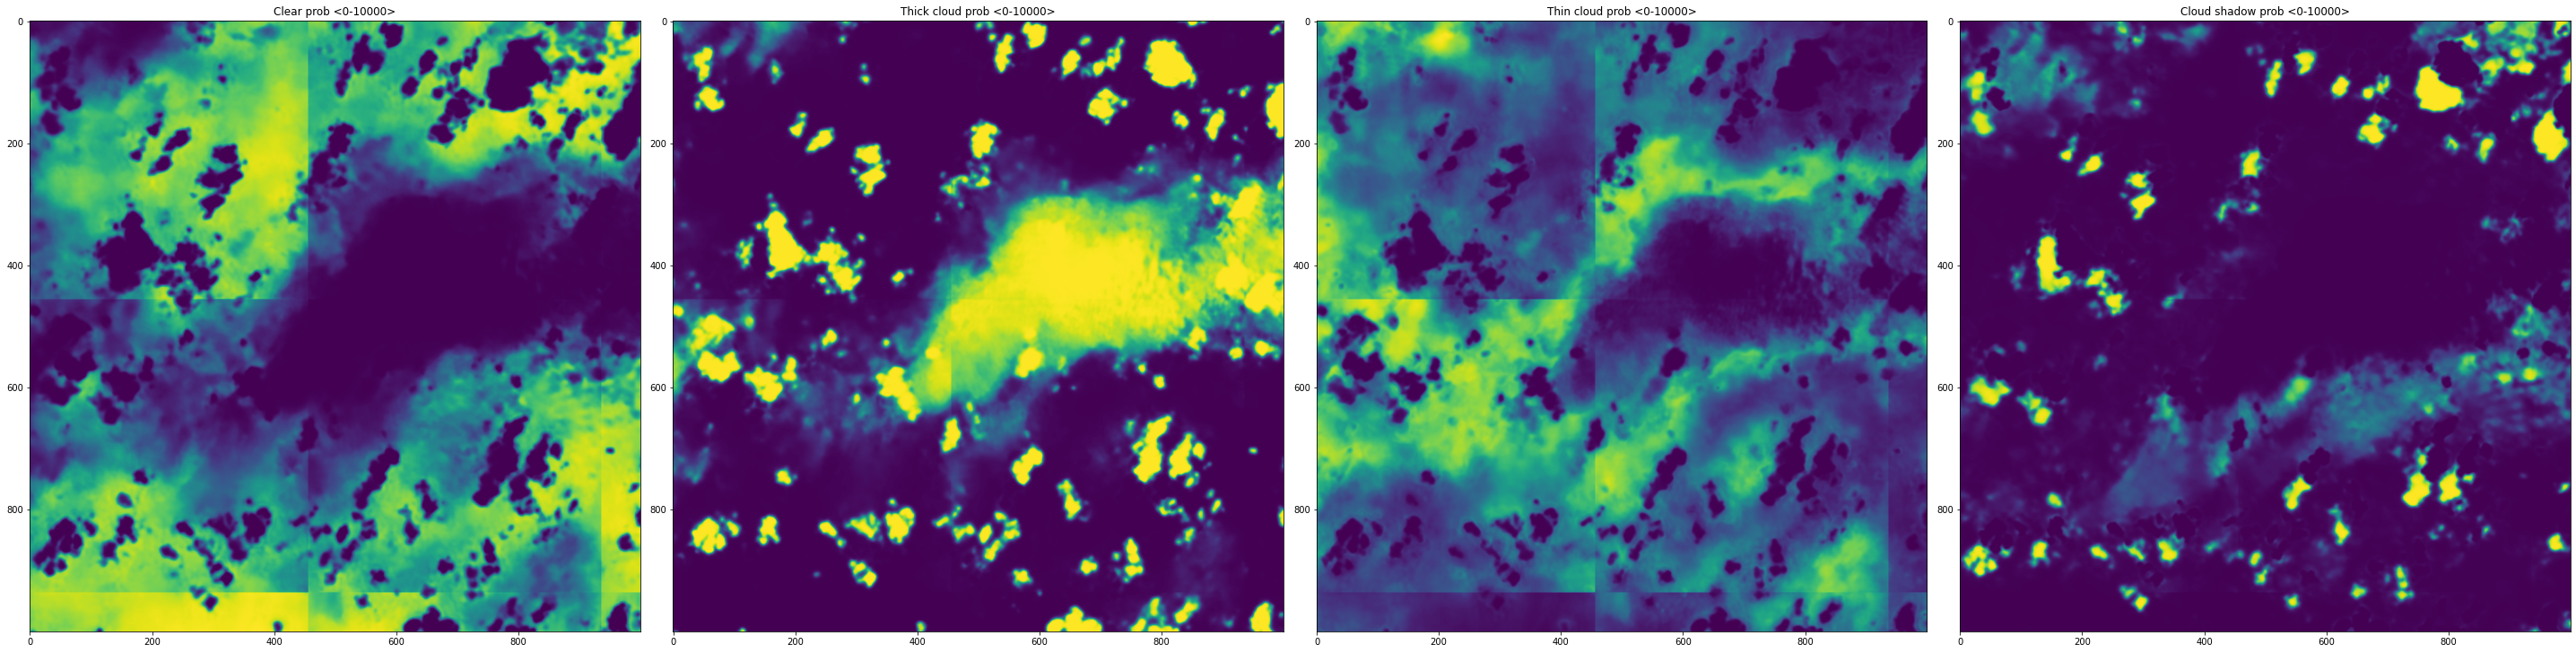

In [ ]:
import matplotlib.pyplot as plt

sl = slice(1000,2000)
fig, ax = plt.subplots(1, 4, figsize=(40, 10), tight_layout=True)

ax[0].imshow(result[0, sl, sl])
ax[0].set_title("Clear prob <0-10000>")
ax[1].imshow(result[1, sl, sl])
ax[1].set_title("Thick cloud prob <0-10000>")
ax[2].imshow(result[2, sl, sl])
ax[2].set_title("Thin cloud prob <0-10000>")
ax[3].imshow(result[3, sl, sl])
ax[3 ].set_title("Cloud shadow prob <0-10000>")

In [ ]:
# @title **plot functions**
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

COLORS_CLOUDSEN12 = np.array(
    [[139, 64, 0], # clear
    [220, 220, 220], # Thick cloud
    [180, 180, 180], # Thin cloud
    [60, 60, 60]], # cloud shadow
    dtype=np.float32
) / 255
INTERPRETATION_CLOUDSEN12 = ["clear", "Thick cloud", "Thin cloud", "Cloud shadow"]

def plot_segmentation_mask(mask, color_array, interpretation_array=None,legend:bool=True, ax=None):
    """
    Args:
        mask: (H, W) np.array
        color_array: colors for values 0,...,len(color_array)-1 of mask
        interpretation_array: interpretation for classes 0, ..., len(color_array)-1
        
    """
    cmap_categorical = colors.ListedColormap(color_array)
    
    norm_categorical = colors.Normalize(vmin=-.5,
                                        vmax=color_array.shape[0]-.5)
    
    color_array = np.array(color_array)
    if interpretation_array is not None:
        assert len(interpretation_array) == color_array.shape[0], f"Different numbers of colors and interpretation {len(interpretation_array)} {color_array.shape[0]}"
    
    
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(mask, cmap=cmap_categorical, norm=norm_categorical,interpolation='nearest')
    if legend:
        patches = []
        for c, interp in zip(color_array, interpretation_array):
            patches.append(mpatches.Patch(color=c, label=interp))
        
        ax.legend(handles=patches,
                  loc='upper right')
    return ax


def plot_cloudSEN12mask(mask, legend:bool=True, ax=None):
    """
    Args:
        mask: (H, W) np.array        
    """
    
    return plot_segmentation_mask(mask=mask,color_array=COLORS_CLOUDSEN12,interpretation_array=INTERPRETATION_CLOUDSEN12,legend=legend,ax=ax)

Text(0.5, 1.0, 'RGB Masked')

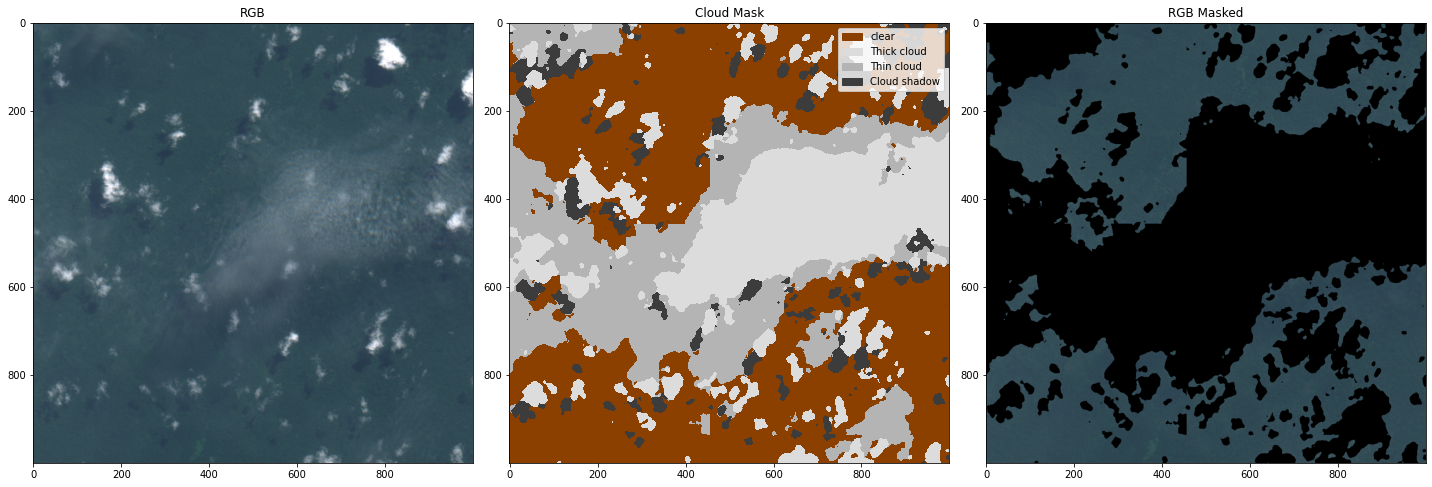

In [ ]:
import xarray as xr

sl = slice(1000,2000)

# plot mask
cloudmask = np.argmax(result.to_numpy(), axis=0)[sl, sl]
rgb = xr.concat([tensor.Red[sl, sl], tensor.Green[sl, sl], tensor.Blue[sl, sl]], "band").to_numpy()
rgb_axis = np.moveaxis(rgb, 0, -1)/3000
rgb_masked = rgb_axis * np.repeat(cloudmask[...,None] < 1,3,axis=2)

fig, ax = plt.subplots(1, 3, figsize=(20, 10), tight_layout=True)
ax[0].imshow(rgb_axis)
ax[0].set_title("RGB")
plot_cloudSEN12mask(cloudmask, ax=ax[1])
ax[1].set_title("Cloud Mask")
ax[2].imshow(rgb_masked)
ax[2].set_title("RGB Masked")

In [ ]:
# Save results
result.rio.to_raster("/content/outensor.tif")